In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
from scipy.stats import norm
from scipy.stats import multivariate_normal
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter
import copy
import matplotlib.colors as mcolors

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
params = {'text.usetex' : True,
          'font.size' : 12,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 
plt.rcParams["figure.autolayout"] = True

In [2]:
# Generate synthetic data
# components = ['level','fourrier','ar']
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 1000

AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# Set seed
np.random.seed(0)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# Generate periodic pattern
components_P = ['level','fourrier']

hyperparameters_P = {'level': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'observation': {'error': 0}}
x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
          'var': np.diag([0,1e-12, 1e-12])}

data_generator_P = generate_one_synthetic_time_series(components = components_P, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters_P, 
                                                    num_steps = num_steps,
                                                    x_init = x_init_P)

# Add periodic patten
data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()
# data_generator.plot()

In [3]:
######################################## Base model ########################################
components = ['trend','fourrier', 'ar']
# components = ['trend', 'ar']

hyperparameters = {'trend': {'process_error_var': 0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
# x_init = {'mu': np.array([5, 0.0, -0.0621]), \
#           'var': np.diag([1e-12, 1E-12, 6.36E-05])}
x_init = {'mu': np.array([5, 0.0, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
          'var': np.diag([1e-12, 1E-12,1e-12, 1E-12, 6.36E-05])}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)

######################################## Meta-AR model ########################################
components_d = ['trend', 'ar']

# expected_detection_time = 52 * 3
# baseline_process_error_var = AR_stationary_var / 1e7
baseline_process_error_var = 1e-6

hyperparameters_d = {'trend': {'process_error_var': baseline_process_error_var, 'phi': 1},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init_d = {'mu': np.array([0, 0.0, -0.0621]), \
          'var': np.diag([1e-12, 1e-12, 6.36E-05])}

kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)

# Anomaly settings
anm_pos = 200
anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
# anm_mag = 0

# Trigger settings
# Randomly generate 500 numbers between 0 and 1000
# trigger_pos = np.random.randint(0, 1000, 500).tolist()
# trigger_pos = [500, 600]
trigger_pos = []


In [4]:
x_last_step = x_init
x_last_step_d = x_init_d
y_pred_mus, y_pred_vars = [], []
LL_mu, LT_mu, AR_mu = [], [], []
LL_var, LT_var, AR_var = [], [], []
LLd_mu, LTd_mu, ARd_mu = [], [], []
LLd_var, LTd_var, ARd_var = [], [], []
y_likelihoods = []
x_likelihoods = []
x_samples_mean = 0.00026317
x_samples_cov = 4.728058038118972e-05
mv_normal_x = multivariate_normal(mean=x_samples_mean, cov=x_samples_cov, allow_singular=True)
for i in range(num_steps):
    # # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)

    if i in trigger_pos:
        x_last_step['mu'][1] += anm_mag
        x_last_step['mu'][0] = x_init['mu'][0] + anm_mag * (i - anm_pos)
        x_last_step['mu'][-1] = 0

    y_pred, x_pred, _ = kf.predict(x_last_step)
    x_updated, y_likelihood, _ = kf.update(data_generator.time_series['y'][i])
    y_likelihoods.append(y_likelihood)

    ############ Meta-AR model ############
    pred_AR, xd_pred, _ = kf_d.predict(x_last_step_d)
    pred_AR['mu'] = pred_AR['mu'].item()
    pred_AR['var'] = pred_AR['var'].item()

    # Smoother equations to update
    target_AR = {'mu': x_pred['mu'][-1], 'var': x_pred['var'][-1,-1]}
    cov_x_AR = xd_pred['var'] @ kf_d.F.T
    xd_updated = kf_d.dist_update(target_AR, pred_AR, xd_pred, cov_x_AR)

    x_likelihood = mv_normal_x.pdf(xd_pred['mu'][1])
    x_likelihoods.append(x_likelihood)

    x_last_step_d = xd_updated
    x_last_step = x_updated

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())

    LLd_mu.append(xd_pred['mu'][0])
    LTd_mu.append(xd_pred['mu'][1])
    ARd_mu.append(xd_pred['mu'][-1])
    LLd_var.append(xd_pred['var'][0,0])
    LTd_var.append(xd_pred['var'][1,1])
    ARd_var.append(xd_pred['var'][-1,-1])

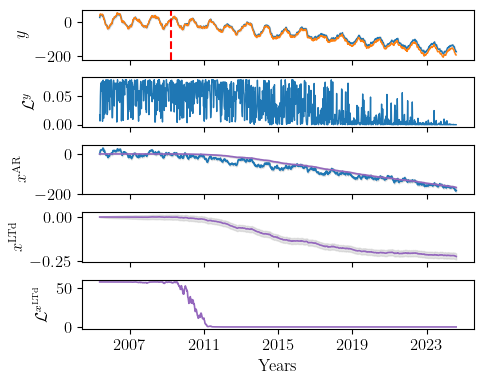

In [ ]:
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
# ax1 = plt.subplot(gs[1])
ax0.plot(data_generator.time_series['timesteps'], y_pred_mus, color=mcolors.TABLEAU_COLORS['tab:blue'], linewidth=1, label='Pred.')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus)-np.sqrt(y_pred_vars), np.array(y_pred_mus)+np.sqrt(y_pred_vars), color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], color=mcolors.TABLEAU_COLORS['tab:orange'], linewidth=1, label='Obs.')
ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anm.')
if len(trigger_pos)>0:
    ax0.axvline(x=trigger_pos[0], color='k', linestyle='--', label='Itv.')
# ax0.legend(ncol=4, loc='lower left')
ax0.set_xticks(np.array([0, 208, 416, 624, 832])+84)
ax0.set_xticklabels([])
ax0.set_ylabel('$y$')
# # Remove figure frame and axis
# ax0.spines['top'].set_visible(False)
# ax0.spines['right'].set_visible(False)
# ax0.spines['left'].set_visible(False)
# ax0.spines['bottom'].set_visible(False)
# ax0.yaxis.set_ticks_position('left')
# ax0.xaxis.set_ticks_position('bottom')
# ax0.set_xticklabels([])
# ax0.set_yticklabels([])
# ax0.set_xticks([])
# ax0.set_yticks([])

ax1.plot(data_generator.time_series['timesteps'], y_likelihoods, linewidth=1, label='Likelihood')
ax1.set_ylabel('$\mathcal{L}^y$')
ax1.set_xticks(np.array([0, 208, 416, 624, 832])+84)
ax1.set_xticklabels([])

ax2.plot(data_generator.time_series['timesteps'], AR_mu, linewidth=1.2, label='LL')
ax2.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
ax2.set_ylabel(r'$x^{\mathrm{AR}}$')
ax2.set_xticks(np.array([0, 208, 416, 624, 832])+84)
ax2.set_xticklabels([])
# ax2.plot(data_generator.time_series['timesteps'], LLd_mu, color=mcolors.TABLEAU_COLORS['tab:purple'], linewidth=1.2, label='LLd')
# ax2.fill_between(data_generator.time_series['timesteps'], np.array(LLd_mu)-np.sqrt(LLd_var), np.array(LLd_mu)+np.sqrt(LLd_var),color='gray', alpha=0.2)

ax3.plot(data_generator.time_series['timesteps'], LTd_mu, color=mcolors.TABLEAU_COLORS['tab:purple'], linewidth=1.2, label='LT')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(LTd_mu)-np.sqrt(LTd_var), np.array(LTd_mu)+np.sqrt(LTd_var),color='gray', alpha=0.2)
ax3.set_ylabel(r'$x^{\mathrm{LTd}}$')
ax3.set_xticks(np.array([0, 208, 416, 624, 832])+84)
ax3.set_xticklabels([])

ax4.plot(data_generator.time_series['timesteps'], x_likelihoods, color=mcolors.TABLEAU_COLORS['tab:purple'], linewidth=1.2, label='Likelihood')
ax4.set_ylabel(r'$\mathcal{L}^{x^{\mathrm{LTd}}}$')
# ax4.set_xticks([0, 208, 416, 624, 832])
ax4.set_xticks(np.array([0, 208, 416, 624, 832])+84)
ax4.set_xticklabels([2007,2011,2015,2019,2023])
ax4.set_xlabel('Years')

plt.tight_layout(h_pad=0.5, w_pad=0.1)
plt.savefig('intervention.png', dpi=300)